# Simulation Examples

In [1]:
import equinox as eqx
import jax.numpy as jnp
import jax.random as rng
import matplotlib.pyplot as plt


import stochastix as stx
from stochastix.utils.visualization import plot_abundance_dynamic

key = rng.PRNGKey(42)

# jax.config.update('jax_enable_x64', True)

plt.rcParams['font.size'] = 18

/Users/francesco/Documents/GitHub/stochastix/stochastix/utils/__init__.py:3: FutureWarning: The 'stochastix.utils.optimization' module is experimental and it may change or be removed without notice in future versions.
  from . import nn, optimization, visualization


## Oscillator

In [2]:
# Define the oscillator reactions using the new API
reactions = [
    stx.Reaction('X0 + X1 -> 2 X1', stx.kinetics.MassAction(0.01)),
    stx.Reaction('X1 + X2 -> 2 X2', stx.kinetics.MassAction(0.01)),
    stx.Reaction('X0 + X2 -> 2 X0', stx.kinetics.MassAction(0.01)),
    stx.Reaction('2 X0 -> X0', stx.kinetics.MassAction(0.0001)),
    stx.Reaction('2 X1 -> X1', stx.kinetics.MassAction(0.0001)),
    stx.Reaction('2 X2 -> X2', stx.kinetics.MassAction(0.0001)),
]

model = stx.ReactionNetwork(reactions)

In [3]:
print(model)

R0:  X0 + X1 -> 2 X1  |  MassAction
R1:  X1 + X2 -> 2 X2  |  MassAction
R2:  X0 + X2 -> 2 X0  |  MassAction
R3:  2 X0 -> X0       |  MassAction
R4:  2 X1 -> X1       |  MassAction
R5:  2 X2 -> X2       |  MassAction


In [4]:
key, subkey = rng.split(key)

x0 = jnp.array([100, 50, 70])
T = 100

sim_results = stx.stochsimsolve(
    subkey,
    model,
    x0,
    T=T,
    max_steps=int(5e5),
)

print('Time overflow:\t', sim_results.time_overflow)

Time overflow:	 False


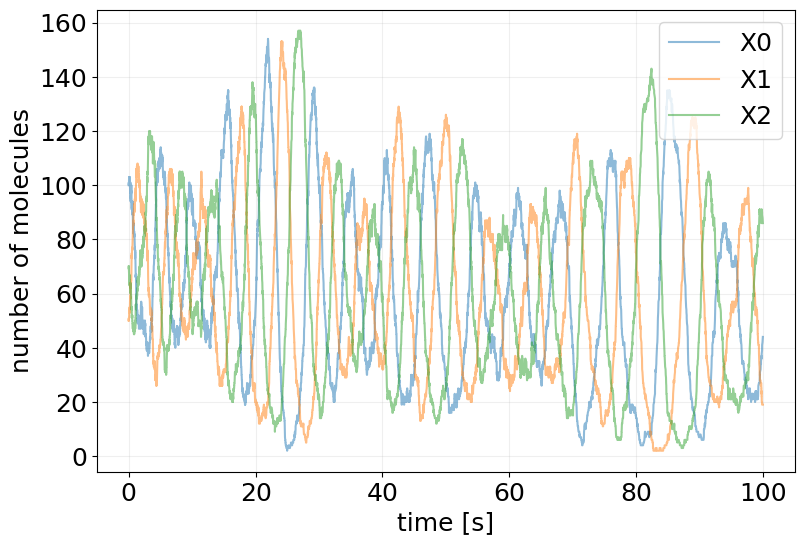

In [5]:
plot_abundance_dynamic(sim_results, time_unit='s');

## Lotka-Volterra Model (Predator-Prey)

In [6]:
# Use the built-in Lotka-Volterra generator
lv_model = stx.generators.lotka_volterra_model(
    alpha=jnp.array(0.1),  # prey reproduction rate
    beta=0.001,  # predation rate
    gamma=0.1,  # predator death rate
)

In [7]:
print(lv_model)

R0 (prey_reproduction):  prey -> 2 prey                 |  MassAction
R1 (predation):          predator + prey -> 2 predator  |  MassAction
R2 (predator_death):     predator -> 0                  |  MassAction


In [8]:
key, subkey = rng.split(key)

x0 = dict(predator=100, prey=50)

sim_results = stx.stochsimsolve(
    subkey,
    lv_model,
    x0,
    T=500,
    max_steps=int(5e4),
)

print('Time overflow:\t', sim_results.time_overflow)

Time overflow:	 False


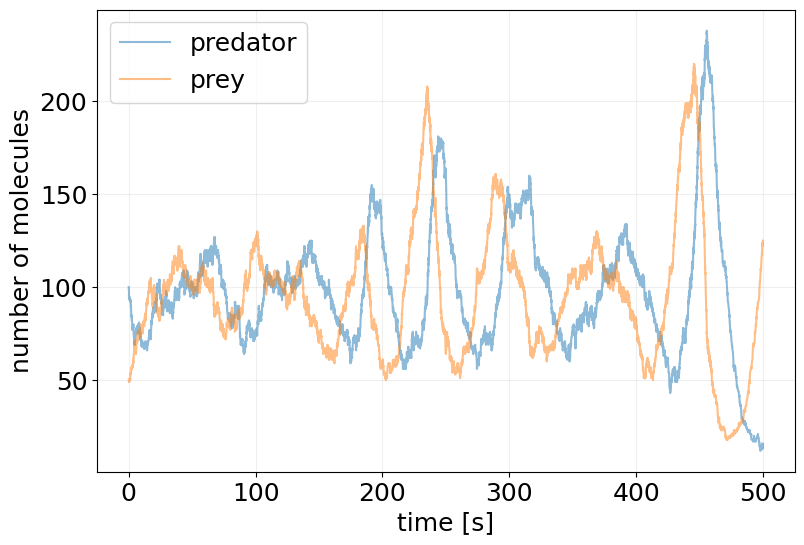

In [9]:
plot_abundance_dynamic(sim_results, time_unit='s');

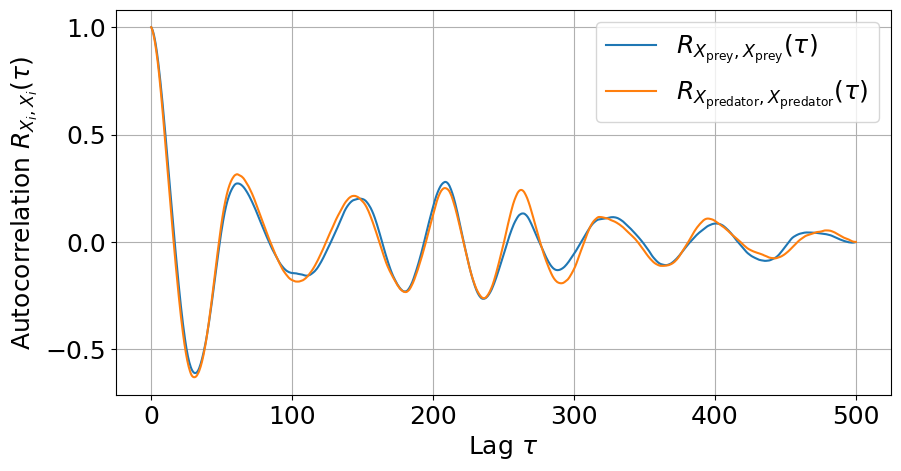

In [ ]:
lags, autocorr1 = stx.analysis.autocorrelation(
    sim_results, species='prey', n_points=1000
)
lags, autocorr2 = stx.analysis.autocorrelation(
    sim_results, species='predator', n_points=1000
)

# Plot autocorrelation
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(lags, autocorr1)
ax.plot(lags, autocorr2)
ax.set_xlabel('Lag $\\tau$')
ax.set_ylabel('Autocorrelation $R_{X_i,X_i}(\\tau)$')
ax.legend(
    [
        '$R_{X_{\\mathrm{prey}},X_{\\mathrm{prey}}}(\\tau)$',
        '$R_{X_{\\mathrm{predator}},X_{\\mathrm{predator}}}(\\tau)$',
    ]
)
ax.grid(True)
plt.show()

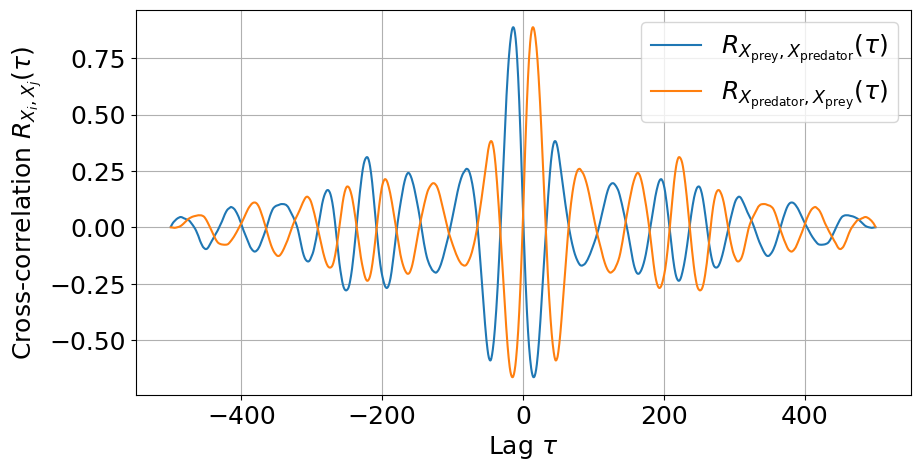

In [11]:
lags, cross_corr1 = stx.analysis.cross_correlation(
    sim_results, species1='prey', species2='predator', n_points=1000
)
lags, cross_corr2 = stx.analysis.cross_correlation(
    sim_results, species1='predator', species2='prey', n_points=1000
)

# Plot cross-correlation
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(lags, cross_corr1)
ax.plot(lags, cross_corr2)
ax.set_xlabel('Lag $\\tau$')
ax.set_ylabel('Cross-correlation $R_{X_i,X_j}(\\tau)$')
ax.legend(
    [
        '$R_{X_{\\mathrm{prey}},X_{\\mathrm{predator}}}(\\tau)$',
        '$R_{X_{\\mathrm{predator}},X_{\\mathrm{prey}}}(\\tau)$',
    ]
)
ax.grid(True)
plt.show()

Test differentiability:

In [12]:
@eqx.filter_jit
def test_loss(network, x0, key):
    sim_results = stx.stochsimsolve(
        key,
        network,
        x0,
        T=500,
        max_steps=int(5e4),
        solver=stx.solvers.DifferentiableDirect(),
    )

    _, cross_corr = stx.analysis.cross_correlation(
        sim_results,
        species1='prey',
        species2='predator',
        n_points=1000,
    )

    return jnp.mean(cross_corr**2)

In [13]:
key, subkey = rng.split(subkey)

eqx.filter_grad(test_loss)(lv_model, x0, key).prey_reproduction.kinetics.k

Array(0.67341566, dtype=float32, weak_type=True)

## SIRS Model

In [14]:
# Use the built-in SIRS generator (with no recovery -> susceptible to get SIR)
sir_model = stx.generators.sirs_model(
    beta=0.005,  # transmission rate
    gamma=0.02,  # recovery rate
    nu=0.01,  # loss of immunity rate (R -> S)
)

In [15]:
print(sir_model)

R0 (infection):         I + S -> 2 I  |  MassAction
R1 (recovery):          I -> R        |  MassAction
R2 (loss_of_immunity):  R -> S        |  MassAction


In [16]:
key, subkey = rng.split(key)

# I, R, S (stored in alphabetical order)
x0 = jnp.array([1, 0, 100])

sim_results = stx.stochsimsolve(
    subkey,
    sir_model,
    x0,
    T=300,
    max_steps=int(5e5),
)

print('Time overflow:\t', sim_results.time_overflow)

Time overflow:	 False


In [17]:
sir_model.species

('I', 'R', 'S')

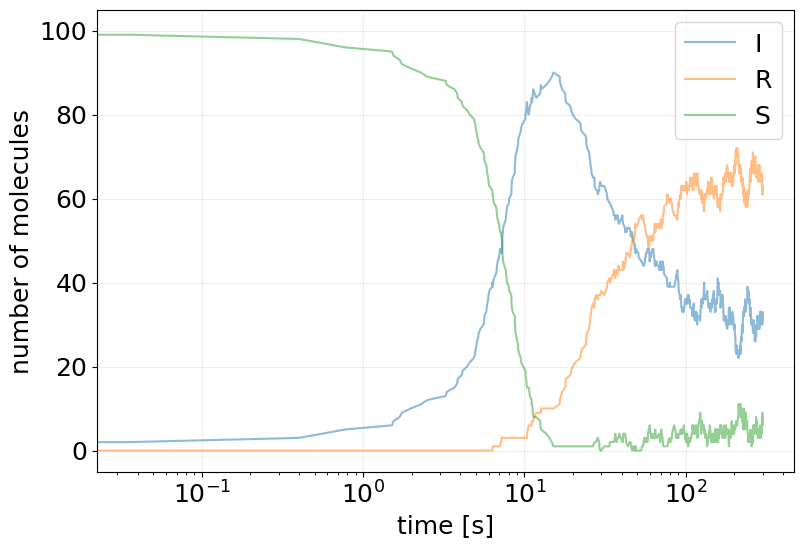

In [18]:
plot_abundance_dynamic(sim_results, time_unit='s', log_x_scale=True);

## Repressilator

In [19]:
# Use the built-in repressilator generator
repressilator = stx.generators.repressilator_model(
    alpha=30.0,  # maximum expression rate
    alpha0=0.0,  # leaky expression rate
    K=30.0,  # half-saturation constant
    beta=0.1,  # degradation rate
    n=3.0,  # Hill coefficient (cooperativity)
)

In [20]:
print(repressilator)

R0 (gene_A_expression):      0 -> A  |  HillRepressor
R1 (gene_B_expression):      0 -> B  |  HillRepressor
R2 (gene_C_expression):      0 -> C  |  HillRepressor
R3 (protein_A_degradation):  A -> 0  |  MassAction
R4 (protein_B_degradation):  B -> 0  |  MassAction
R5 (protein_C_degradation):  C -> 0  |  MassAction


In [21]:
key, subkey = rng.split(key)

x0 = jnp.ones(repressilator.n_species) * 10

sim_results = stx.stochsimsolve(subkey, repressilator, x0, T=300.0, max_steps=int(5e5))

print('Time overflow:\t', sim_results.time_overflow)

Time overflow:	 False


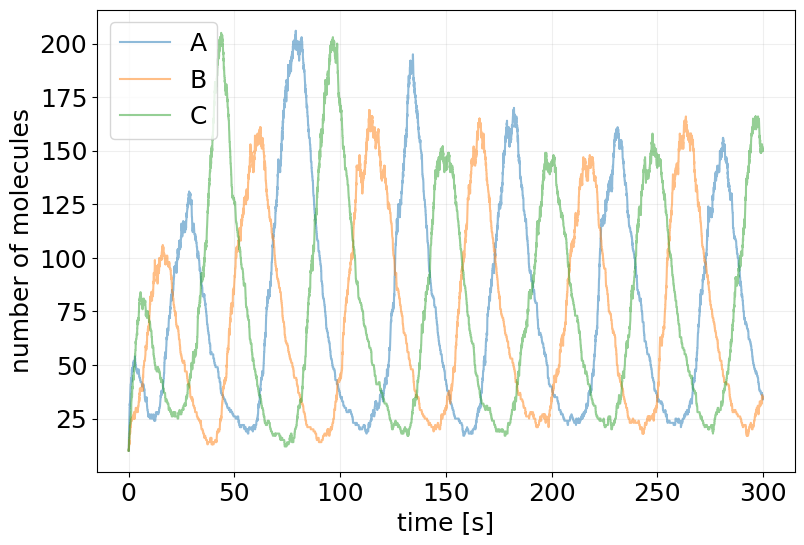

In [22]:
plot_abundance_dynamic(sim_results, time_unit='s');

## C2-FFL - Coherent Type 2 Feed-Forward Loop 

In [23]:
from stochastix import Reaction, ReactionNetwork
from stochastix.kinetics import HillActivator, HillRR, MassAction

In [24]:
c2_ffl_reactions = [
    Reaction(
        '0 -> Y',
        HillActivator(regulator='X', v=50.0, K=20.0, n=3.0),
        name='Y_production',
    ),
    Reaction(
        '0 -> Z',
        HillRR('X', 'Y', v=50.0, K1=40.0, K2=5.0, n1=3.0, n2=3.0, logic='and'),
        name='Z_production',
    ),
    Reaction('Y -> 0', MassAction(k=1.0), name='Y_degradation'),
    Reaction('Z -> 0', MassAction(k=1.0), name='Z_degradation'),
]

c2_ffl = ReactionNetwork(c2_ffl_reactions)

print(c2_ffl)

R0 (Y_production):   0 -> Y  |  HillActivator
R1 (Z_production):   0 -> Z  |  HillRR
R2 (Y_degradation):  Y -> 0  |  MassAction
R3 (Z_degradation):  Z -> 0  |  MassAction


### Static Inputs

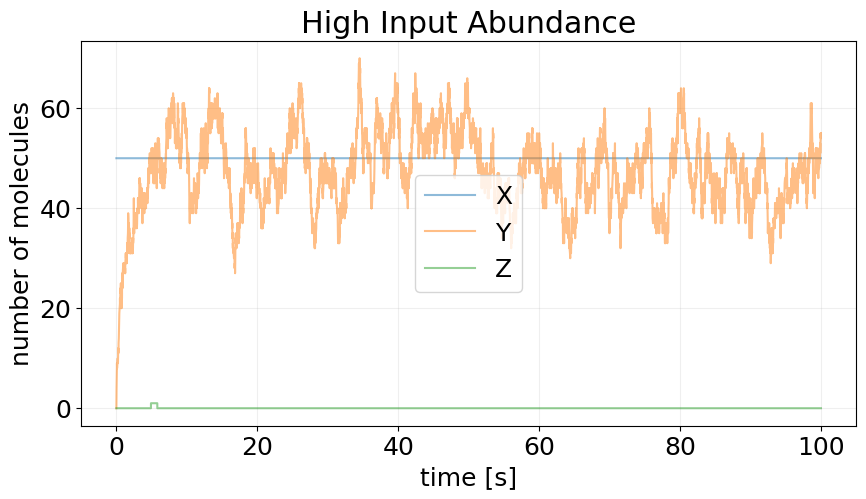

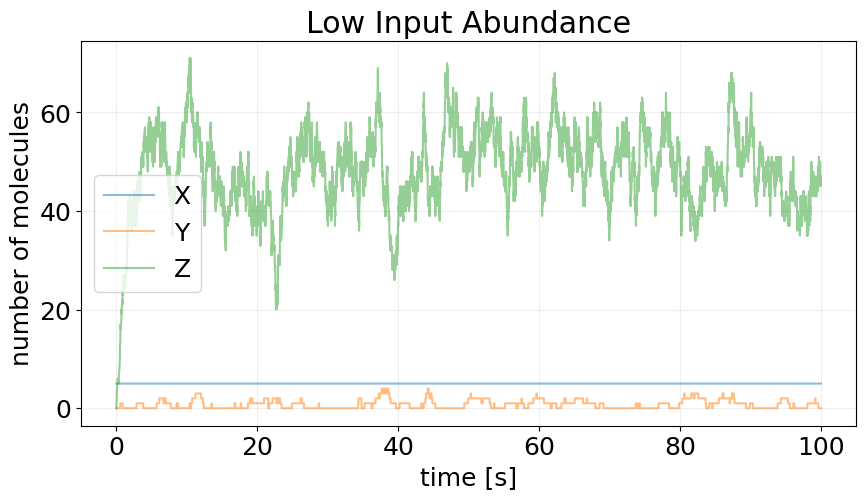

In [25]:
key, subkey_high, subkey_low = rng.split(key, 3)

# x0_high = jnp.array([50.0, 0.0, 0.0])
x0_high = dict(X=50.0, Y=0.0, Z=0.0)

# x0_low = jnp.array([5.0, 0.0, 0.0])
x0_low = dict(X=5.0, Y=0.0, Z=0.0)

T = 100.0

sim_high = stx.stochsimsolve(subkey_high, c2_ffl, x0_high, T=T, max_steps=int(5e5))
sim_low = stx.stochsimsolve(subkey_low, c2_ffl, x0_low, T=T, max_steps=int(5e5))

_, ax = plt.subplots(figsize=(10, 5))
plot_abundance_dynamic(sim_high, time_unit='s', ax=ax)
ax.set_title('High Input Abundance')

_, ax = plt.subplots(figsize=(10, 5))
plot_abundance_dynamic(sim_low, time_unit='s', ax=ax)
ax.set_title('Low Input Abundance');

### Dynamic Input (Time-controlled species)

In [26]:
from stochastix.controllers import Timer

controlled_species = 'X'
time_triggers = jnp.array([20.0, 60.0, 80.0])
species_t = jnp.array([0.0, 50.0, 15.0])[:, None]

timed_controller = Timer(controlled_species, time_triggers, species_t)

In [27]:
timed_controller

Timer(
  controlled_species=('X',),
  time_triggers=(20.0, 60.0, 80.0),
  species_at_triggers=((0.0,), (50.0,), (15.0,))
)

In [28]:
key, subkey = rng.split(key)

x0_high = jnp.array([50.0, 0.0, 0.0])

sim_ctrl = stx.stochsimsolve(
    subkey_high,
    c2_ffl,
    x0_high,
    T=100.0,
    controller=timed_controller,
    max_steps=int(5e5),
)

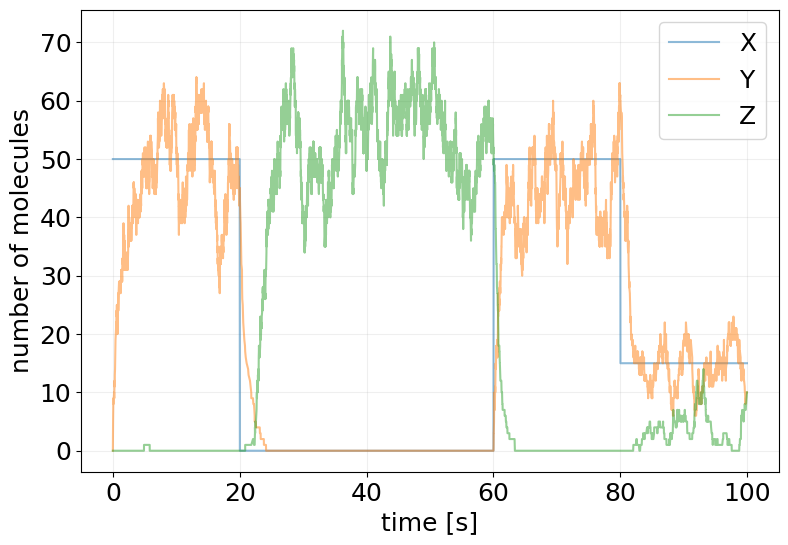

In [29]:
plot_abundance_dynamic(sim_ctrl, time_unit='s');